## Loading the Test and Train datasets

In [1]:
# Loaded variable 'df' from URI: c:\Users\james\OneDrive\Documents\GitHub\Kaggle-Competitions\Predicting Student Test Scores\data.csv
import pandas as pd
test = pd.read_csv(r'c:\Users\james\OneDrive\Documents\GitHub\Kaggle-Competitions\Predicting Student Test Scores\test.csv')
train = pd.read_csv(r'c:\Users\james\OneDrive\Documents\GitHub\Kaggle-Competitions\Predicting Student Test Scores\train.csv')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [2]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


Lots of catagorical variables

exam_score is float

## EDA

In [3]:
train.shape

(630000, 13)

In [4]:
train.columns

Index(['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [5]:
# Data types and missingness
display(train.dtypes)
train.isna().sum().sort_values(ascending=False)

id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [6]:
# summary stats
train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


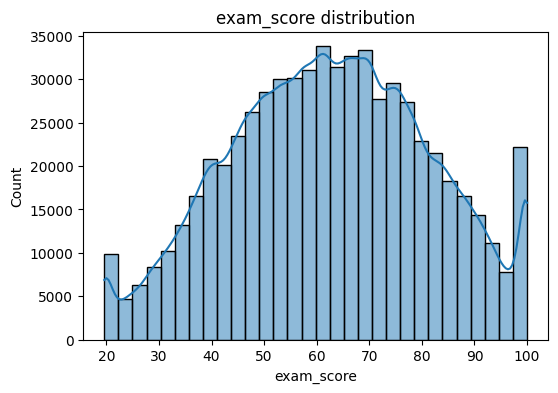

In [7]:
# target distributions

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(train["exam_score"], bins=30, kde=True)
plt.title("exam_score distribution")
plt.show()

Looks like a normal distibution, with the majority of scores from 50 to 70. Its interesting to note that the last bin represening around the 97-100 score mark is an outlier due to its surprisingly high count compared to the previous bins. This could indicate that more people are all 100 score than other scores as this is a limit, people are more likely to hit the limit than an abritrary number inbetween.

In [8]:
# Correlations - nums

num_cols = train.select_dtypes(include="number").columns
corr = train[num_cols].corr()["exam_score"].sort_values(ascending=False)
corr

exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64

Study hours has the strongest positive correlation fo 0.76, whilst ages looks to have little to no correlation. These results fit what I expected.

In [9]:
# 6) Categorical feature impact (mean target by category)
cat_cols = train.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    print("\n", col)
    display(train.groupby(col)["exam_score"].mean().sort_values(ascending=False).head(10))


 gender


gender
other     62.781191
female    62.563220
male      62.175561
Name: exam_score, dtype: float64


 course


course
bba        63.232038
bca        62.586227
b.com      62.537726
b.tech     62.519707
diploma    62.404354
b.sc       62.295491
ba         61.886931
Name: exam_score, dtype: float64


 internet_access


internet_access
yes    62.509172
no     62.478038
Name: exam_score, dtype: float64


 sleep_quality


sleep_quality
good       67.884885
average    62.662000
poor       56.995470
Name: exam_score, dtype: float64


 study_method


study_method
coaching         69.266665
mixed            65.101735
group study      60.531838
online videos    59.727607
self-study       57.700155
Name: exam_score, dtype: float64


 facility_rating


facility_rating
high      66.707126
medium    63.028954
low       57.954546
Name: exam_score, dtype: float64


 exam_difficulty


exam_difficulty
hard        62.671693
moderate    62.606060
easy        62.214401
Name: exam_score, dtype: float64

No impact columns : 
1. exam difficulty
2. internet access
3. gender
4. course has little to no power

In [10]:
# checking for dups
# 7) Check for duplicates (optional)
train.duplicated().sum()


np.int64(0)

# Model Set-up

## Cross Validation

In [11]:
from sklearn.model_selection import train_test_split

target = "exam_score"

X = train.drop(columns=[target])
y = train[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Identifying column types

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(include="number").columns


In [13]:
# Preprosessing and encoding

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [16]:
# model and pipeline

from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])


In [18]:
# Train and evaluate
import numpy as np
from sklearn.metrics import mean_squared_error

clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

rsme = np.sqrt(mean_squared_error(y_valid, preds))
rsme

np.float64(8.959799281562482)

### rsme of 8.96 (ElasticNet)

This seems like an OK start